# Creating the baseline model

Let's create a baseline model on the raw data, with no data manipulation 

All the images are pretty much uniform so let's just see what a baseline score could be
From there, we can always improve

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
base_dir = "../raw_data"

for root, dirs, files in os.walk(base_dir):
    print(root, ":", len(files))

../raw_data : 1
../raw_data/contempt : 208
../raw_data/fear : 570
../raw_data/surprise : 775
../raw_data/sadness : 746
../raw_data/neutrality : 524
../raw_data/happiness : 1406
../raw_data/anger : 890
../raw_data/disgust : 439


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(224,224),
    color_mode="grayscale",
    batch_size=32,
    label_mode="categorical"   # one-hot encoding
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=(224,224),
    color_mode="grayscale",
    batch_size=32,
    label_mode="categorical"
)

Found 5558 files belonging to 8 classes.
Using 4447 files for training.
Found 5558 files belonging to 8 classes.
Using 1111 files for validation.


In [16]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>

2025-09-01 17:39:59.930121: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:39:59.934809: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:39:59.940359: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:39:59.952664: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:39:59.953364: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:39:59.953880: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01

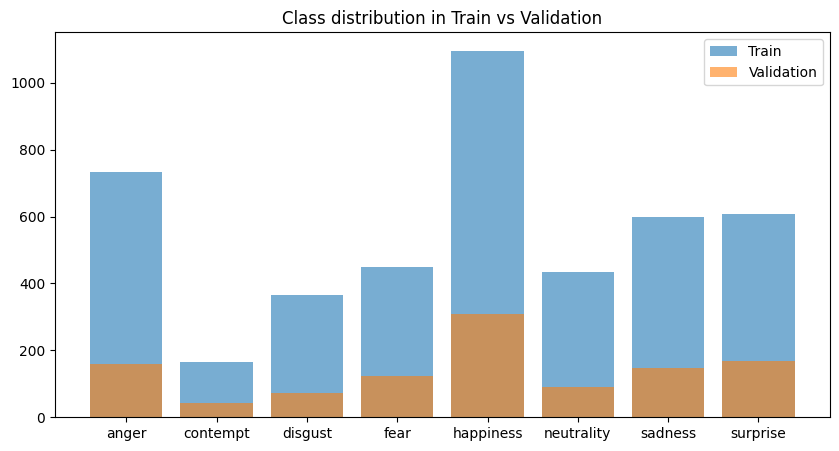

In [19]:
def get_label_distribution(dataset):
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(np.argmax(labels.numpy(), axis=1))  # convert one-hot → class index
    return np.array(all_labels)

train_labels = get_label_distribution(train_ds)
val_labels = get_label_distribution(val_ds)

# Count occurrences
train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)

class_names = train_ds.class_names

plt.figure(figsize=(10,5))
plt.bar(class_names, train_counts, alpha=0.6, label="Train")
plt.bar(class_names, val_counts, alpha=0.6, label="Validation")
plt.legend()
plt.title("Class distribution in Train vs Validation")
plt.show()

In [20]:
def get_label_counts(dataset, class_names, one_hot=True):
    all_labels = []
    for _, labels in dataset:
        if one_hot:
            all_labels.extend(np.argmax(labels.numpy(), axis=1))  # one-hot → class index
        else:
            all_labels.extend(labels.numpy())  # already integers
    counts = np.bincount(all_labels, minlength=len(class_names))
    return counts

In [21]:
one_hot = True   # set to False if you used label_mode="int"

train_counts = get_label_counts(train_ds, class_names, one_hot)
val_counts   = get_label_counts(val_ds, class_names, one_hot)

df_counts = pd.DataFrame({
    "Class": class_names,
    "Train Count": train_counts,
    "Validation Count": val_counts
})

display(df_counts)

2025-09-01 17:41:11.797001: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.817503: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.818205: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.825550: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.826967: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:41:11.828869: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01

,Class,Train Count,Validation Count
0,anger,732,158
1,contempt,164,44
2,disgust,366,73
3,fear,448,122
4,happiness,1096,310
5,neutrality,434,90
6,sadness,599,147
7,surprise,608,167


In [17]:
for images, labels in train_ds.take(1):  # take 1 batch
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("First label:", labels[0])

Images shape: (32, 224, 224, 1)
Labels shape: (32, 8)
First label: tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0.], shape=(8,), dtype=float32)


2025-09-01 17:38:53.458376: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:38:53.468604: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-09-01 17:39:17.089721: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2025-09-01 17:39:17.131672: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


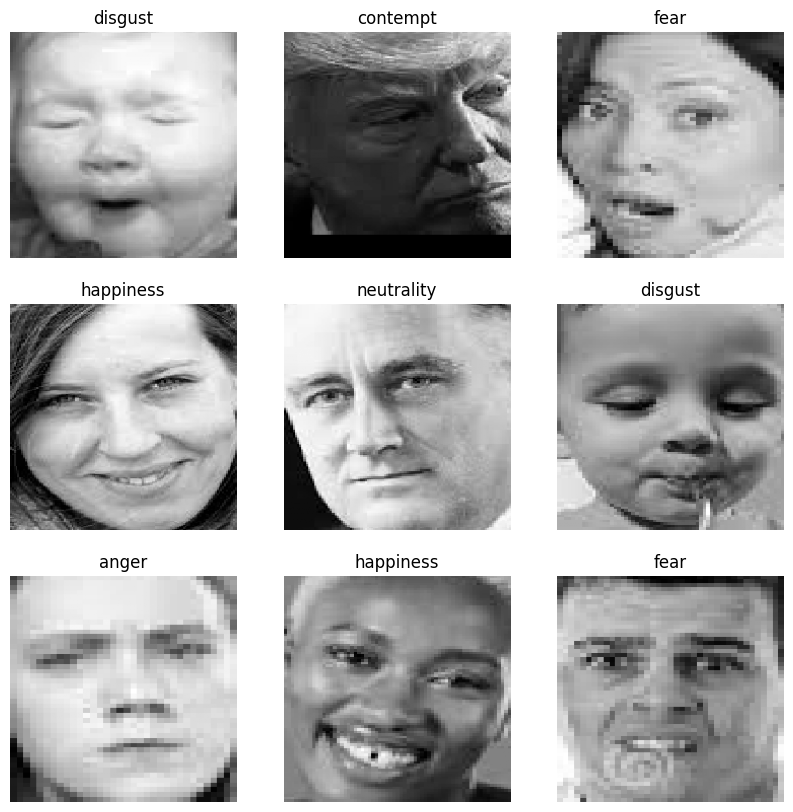

In [18]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        label_index = labels[i].numpy().argmax()  # if one-hot
        plt.title(class_names[label_index])
        plt.axis("off")

In [13]:
model = Sequential()

model.add(Input(shape=(224,224,1)))

model.add(layers.Conv2D(6, kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(4, kernel_size=(3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='softmax'))


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 4)    │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 193600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │     1,548,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,549,088 (5.91 MB)

 Trainable params: 1,549,088 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",   # one-hot
    metrics=["accuracy"]
)